In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json

## Data

In [3]:
PATH = Path('data/carvana')
MASKS_FN = 'train_masks.csv'
META_FN = 'metadata.csv'
masks_csv = pd.read_csv(PATH/MASKS_FN)
meta_csv = pd.read_csv(PATH/META_FN)

In [4]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

In [5]:
TRAIN_DN = 'train-128'
MASKS_DN = 'train_masks-128'
sz = 128
bs = 64
nw = 16

In [6]:
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): return open_image(os.path.join(self.path, self.y[i]))
    def get_c(self): return 0

In [7]:
x_names = np.array([Path(TRAIN_DN)/o for o in masks_csv['img']])
y_names = np.array([Path(MASKS_DN)/f'{o[:-4]}_mask.png' for o in masks_csv['img']])

In [8]:
val_idxs = list(range(1008))
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)

In [9]:
aug_tfms = [RandomRotate(4, tfm_y=TfmType.PIXEL),
            RandomFlip(tfm_y=TfmType.PIXEL),
            RandomLighting(0.05, 0.05)]

In [10]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.PIXEL, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)
denorm = md.trn_ds.denorm

## Simple upsample

In [11]:
f = resnet34
cut,lr_cut = model_meta[f]

In [12]:
def get_base():
    layers = cut_model(f(True), cut)
    return nn.Sequential(*layers)

In [13]:
def mask_loss(pred,targ):
    return F.binary_cross_entropy_with_logits(pred[:,0],targ[...,0])

def mask_acc(pred,targ): return accuracy_multi(pred[:,0], targ[...,0], 0.)

In [14]:
def dice(pred, targs):
    m1 = (pred[:,0]>0).float()
    m2 = targs[...,0]
    return 2. * (m1*m2).sum() / (m1+m2).sum()

In [15]:
class StdUpsample(nn.Module):
    def __init__(self, nin, nout):
        super().__init__()
        self.conv = nn.ConvTranspose2d(nin, nout, 2, stride=2)
        self.bn = nn.BatchNorm2d(nout)
        
    def forward(self, x): return self.bn(F.relu(self.conv(x)))

In [16]:
class Upsample34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.up1 = StdUpsample(512,256)
        self.up2 = StdUpsample(256,256)
        self.up3 = StdUpsample(256,256)
        self.up4 = StdUpsample(256,256)
        self.up5 = nn.ConvTranspose2d(256, 1, 2, stride=2)
        
    def forward(self,x):
        x = F.relu(self.rn(x))
        x = self.up1(x)
        x = self.up2(x)
        x = self.up3(x)        
        x = self.up4(x)
        x = self.up5(x)
        return x

In [17]:
m_base = get_base()

In [18]:
class UpsampleModel():
    def __init__(self,model,name='upsample'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model)[1:]]

In [19]:
m = to_gpu(Upsample34(m_base))
models = UpsampleModel(m)

In [20]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=mask_loss
learn.metrics=[mask_acc,dice]

In [21]:
learn.freeze_to(1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 86%|█████████████████████████████████████████████████████████████          | 55/64 [00:22<00:03,  2.46it/s, loss=3.21]

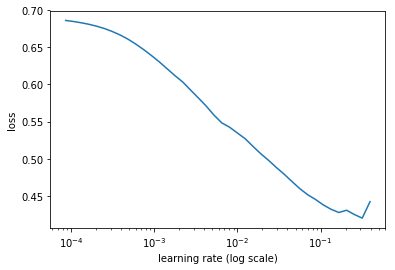

In [62]:
learn.lr_find()
learn.sched.plot()

In [22]:
lr=4e-2

In [23]:
learn.fit(lr,1,cycle_len=4,use_clr=(20,8))

A Jupyter Widget

epoch      trn_loss   val_loss   mask_acc   dice           
    0      0.146828   0.10287    0.962235   0.900971  
    1      0.096188   0.053184   0.97877    0.949509        
    2      0.079225   0.045408   0.981577   0.955658        
    3      0.072457   0.040401   0.985645   0.96535         



[0.040401142, 0.98564491793513298, 0.96535015234249877]

In [25]:
learn.save('tmp')

In [27]:
learn.load('tmp')

In [26]:
learn.unfreeze()
learn.bn_freeze(True)
lrs = np.array([lr/100,lr/10,lr])/2

In [27]:
learn.fit(lrs,1,cycle_len=4,use_clr=(20,8))

A Jupyter Widget

epoch      trn_loss   val_loss   mask_acc   dice            
    0      0.067827   0.043505   0.983957   0.96177   
    1      0.064158   0.036939   0.985748   0.965802        
    2      0.059634   0.030121   0.987953   0.970901        
    3      0.060337   0.030472   0.988357   0.971838        



[0.030472172, 0.98835676908493042, 0.97183782671856789]

In [28]:
learn.save('128')

## U-net (ish)

In [157]:
[o.features.size() for o in m.sfs]

[torch.Size([64, 64, 32, 32]),
 torch.Size([64, 128, 16, 16]),
 torch.Size([64, 256, 8, 8]),
 torch.Size([64, 512, 4, 4])]

In [38]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [39]:
class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.bn(F.relu(cat_p))

In [40]:
class Unet34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.sfs = [SaveFeatures(rn[i]) for i in [2,4,5,6]]
        self.up1 = UnetBlock(512,256,256)
        self.up2 = UnetBlock(256,128,256)
        self.up3 = UnetBlock(256,64,256)
        self.up4 = UnetBlock(256,64,256)
        self.up5 = nn.ConvTranspose2d(256, 1, 2, stride=2)
        
    def forward(self,x):
        x = F.relu(self.rn(x))
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x)
        return x

In [41]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UpsampleModel(m)

In [42]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=mask_loss
learn.metrics=[mask_acc,dice]

In [43]:
learn.freeze_to(1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

  0%|                                                                                           | 0/64 [00:00<?, ?it/s]


Exception in thread Thread-14:
Traceback (most recent call last):
  File "C:\Users\j\Anaconda3\envs\fastai\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\j\Anaconda3\envs\fastai\lib\site-packages\tqdm\_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "C:\Users\j\Anaconda3\envs\fastai\lib\_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



 92%|█████████████████████████████████████████████████████████████████▍     | 59/64 [00:22<00:01,  2.68it/s, loss=2.45]


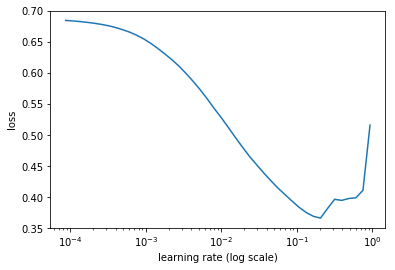

In [53]:
learn.lr_find()
learn.sched.plot()

In [44]:
learn.fit(lr,1,cycle_len=8,use_clr=(20,8))

A Jupyter Widget

  2%|▏         | 1/64 [00:02<02:52,  2.74s/it, loss=0.701]  


Exception in thread Thread-14:
Traceback (most recent call last):
  File "/home/jhoward/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/jhoward/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/jhoward/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   mask_acc   dice           
    0      0.114141   0.055594   0.979138   0.950988  
    1      0.076082   0.034151   0.98702    0.969116        
    2      0.06474    0.03179    0.987512   0.970189        
    3      0.059553   0.031723   0.98741    0.970142        
    4      0.056499   0.023402   0.991014   0.978338        
    5      0.052846   0.022835   0.99128    0.978904        
    6      0.050358   0.021523   0.991672   0.979886        
    7      0.049454   0.021486   0.991822   0.980257        



[0.021485629, 0.99182162806391716, 0.98025651779710943]

In [45]:
learn.save('128urn-tmp')

In [35]:
learn.load('128urn-tmp')

In [46]:
learn.unfreeze()
learn.bn_freeze(True)
lrs = np.array([lr/100,lr/10,lr])

In [47]:
learn.fit(lrs,1,cycle_len=40,use_clr=(20,10))

A Jupyter Widget

epoch      trn_loss   val_loss   mask_acc   dice            
    0      0.050679   0.021842   0.991587   0.979667  
    1      0.05208    0.024761   0.990023   0.975578        
    2      0.053186   0.02313    0.991191   0.978817        
    3      0.052248   0.022841   0.991006   0.978342        
    4      0.0514     0.020944   0.991963   0.980566        
    5      0.051177   0.022671   0.99178    0.980126        
    6      0.049078   0.020343   0.992485   0.98194         
    7      0.049164   0.020444   0.992138   0.981044        
    8      0.048888   0.019091   0.992673   0.982312        
    9      0.045927   0.018152   0.993092   0.983344        
    10     0.046559   0.018934   0.992939   0.982959        
    11     0.047449   0.019952   0.992529   0.982051        
    12     0.046684   0.018603   0.99292    0.98292         
    13     0.047879   0.018464   0.992952   0.982972        
    14     0.045955   0.017765   0.9932     0.983585        
    15     0.046353   0.017213

[0.015830785, 0.99421326443552971, 0.98605310861564677]

In [48]:
learn.save('128urn-0')

In [26]:
learn.load('128urn-0')

In [49]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

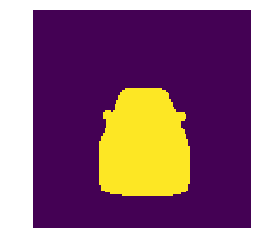

In [50]:
# ax = show_img(denorm(x)[0])
show_img(py[0][0]>0);

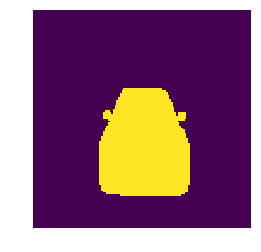

In [51]:
# ax = show_img(denorm(x)[0])
show_img(y[0,...,-1]);

## 512x512

In [52]:
sz=512
bs=16

In [53]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.PIXEL, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=4, classes=None)
denorm = md.trn_ds.denorm

In [54]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UpsampleModel(m)

In [55]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=mask_loss
learn.metrics=[mask_acc,dice]

learn.freeze_to(1)

In [56]:
learn.load('128urn-0')

In [57]:
learn.fit(lr,1,cycle_len=5,use_clr=(20,5))

A Jupyter Widget

epoch      trn_loss   val_loss   mask_acc   dice              
    0      0.055171   0.029512   0.990565   0.976689  
    1      0.04767    0.026559   0.992788   0.982805          
    2      0.046143   0.017681   0.993786   0.985221          
    3      0.041874   0.015712   0.994745   0.987344          
    4      0.040104   0.014559   0.994997   0.987976          



[0.01455932, 0.99499698290749206, 0.9879760943864917]

In [58]:
learn.save('512urn-tmp')

In [65]:
learn.unfreeze()
learn.bn_freeze(True)

In [66]:
learn.fit(lrs,1,cycle_len=8,use_clr=(20,8))

A Jupyter Widget

epoch      trn_loss   val_loss   mask_acc   dice              
    0      0.043127   0.017267   0.99445    0.986631  
    1      0.053838   0.025137   0.99249    0.981813          
    2      0.046597   0.021283   0.993914   0.985367          
    3      0.046402   0.020839   0.994046   0.985722          
    4      0.04063    0.015863   0.994557   0.986934          
    5      0.04021    0.01521    0.994798   0.987506          
    6      0.039451   0.014182   0.995017   0.988034          
    7      0.039235   0.01436    0.995088   0.988208          



[0.014360294, 0.99508800582280232, 0.98820777396046389]

In [67]:
learn.save('512urn')

In [26]:
learn.load('512urn')

In [68]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

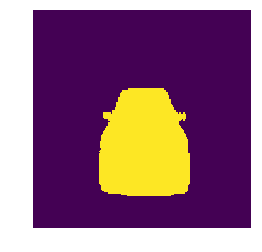

In [69]:
show_img(py[0][0]>0);

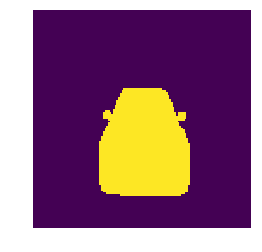

In [70]:
show_img(y[0,...,-1]);

## 1024x1024

In [71]:
sz=1024
bs=4

In [72]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.PIXEL, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=4, classes=None)
denorm = md.trn_ds.denorm

In [73]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UpsampleModel(m)

In [74]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=mask_loss
learn.metrics=[mask_acc,dice]

learn.freeze_to(1)

In [75]:
learn.load('512urn')

In [76]:
learn.fit(lr,1,cycle_len=2,use_clr=(20,4))

A Jupyter Widget

epoch      trn_loss   val_loss   mask_acc   dice                
    0      0.045602   0.022743   0.993469   0.984297  
    1      0.035483   0.014958   0.995233   0.988581            



[0.014958422, 0.99523345723984735, 0.98858082166731231]

In [77]:
learn.save('1024urn-tmp')

In [78]:
learn.unfreeze()
learn.bn_freeze(True)

In [79]:
learn.fit(lrs/2,1,cycle_len=4,use_clr=(20,8))

A Jupyter Widget

epoch      trn_loss   val_loss   mask_acc   dice                
    0      0.047038   0.023661   0.994382   0.986399  
    1      0.030798   0.013738   0.995398   0.988932            
    2      0.045454   0.020875   0.995136   0.988159            
    3      0.028433   0.012486   0.995906   0.99017             



[0.012486176, 0.99590563679498334, 0.99016996905950405]

In [81]:
learn.save('1024urn')

In [26]:
learn.load('1024urn')

In [82]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

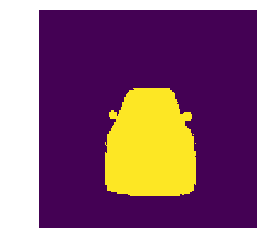

In [83]:
show_img(py[0][0]>0);

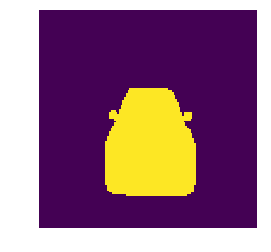

In [84]:
show_img(y[0,...,-1]);